# Compare word2vec training  iterations (AllPositive dataset)

In [1]:
import os
import sys
import gensim
import numpy as np

base = "data"
dataset = "nist"
kind = "in_database"

model_name = kind + "_over10perc"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

%load_ext autoreload
%autoreload 2

### Import pre-processed dataset "Unique InchiKeys"

In [37]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing

spectrums_val = [spectrum_processing(s) for s in load_from_msp(data_val_path)]
spectrums_val = [s for s in spectrums_val if s is not None]
print("number of spectra:", len(spectrums_val))

number of spectra: 22921


## Load pretrained spec2vec models and calculate scores

In [41]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

In [42]:
documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums_val]

In [43]:
documents[0].words[:10]

['peak@12',
 'peak@13',
 'peak@14',
 'peak@15',
 'peak@24',
 'peak@25',
 'peak@26',
 'peak@27',
 'peak@28',
 'peak@29']

### Load reference scores

In [44]:
filename = "gas2vec/similarity_nist_val/in_database/tanimoto_scores.npy"
matrix_similarities_fingerprint_daylight = np.load(filename)

In [45]:
from spec2vec_plotting_functions import plot_precentile

## Actual score calculation
+ Using ``Spec2Vec`` with ``intensity_weighting_power=0.5``.
+ Calculate matrix of all-vs-all similarity scores.
+ Iterate over trained models after different numbers of iterations.

In [46]:
!pwd

/auto/brno6/home/xstary1/raims


In [ ]:
path_models = "gas2vec"

for iteration in [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]:
    filename = f"{model_name}_iter_{iteration}.model"
    model_file = os.path.join(path_models, filename)

    # Load pretrained model
    model = gensim.models.Word2Vec.load(model_file)
    
    # Score calculations
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=15)
    similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
    print("u")
    # Compare to reference scores
    percentile_spec2vec = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

    filename = os.path.join("gas2vec/iterations", "percentile_spec2vec_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec)
    
    filename = os.path.join("gas2vec/iterations", "similarities_spec2vec_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec)

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.17%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.55%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.16%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.53%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.37%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.70%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 2 word(s) missing in the model.

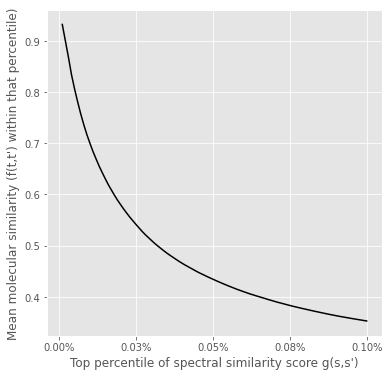

In [51]:
path_models = "gas2vec"

iteration=100

filename = f"{model_name}.model"
model_file = os.path.join(path_models, filename)

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)
    
# Score calculations
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=15)
similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
# Compare to reference scores
percentile_spec2vec = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

filename = os.path.join("gas2vec/iterations", "percentile_spec2vec_iter_{}.npy".format(iteration))
np.save(filename, percentile_spec2vec)
    
filename = os.path.join("gas2vec/iterations", "similarities_spec2vec_iter_{}.npy".format(iteration))
np.save(filename, percentile_spec2vec)

## Compare results

In [7]:
path_data = "gas2vec/iterations"

percentiles = []
for iteration in [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90]:
    
    filename = os.path.join(path_data, "percentile_spec2vec_iter_{}.npy".format(iteration))
    percentiles.append(np.load(filename))
    

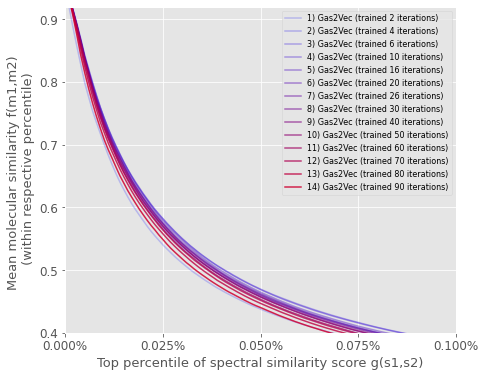

In [8]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]
iterations = [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]
iterations_plot = [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]

color_count = 0
color_max = len(iterations_plot) + 1
for i, percentile in enumerate(percentiles):
    if iterations[i] in iterations_plot:
        plt.plot(x_percentiles, percentiles[i], 
                 color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
                 label='{}) Gas2Vec (trained {} iterations)'.format((color_count+1), iterations[i]))
        color_count += 1

i = 9    
# plt.plot(x_percentiles, percentiles[i], 
#          "--", color="black",
#          label='selected: Spec2Vec (trained {} iterations on UniqueInchikeys)'.format(iterations[i]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
plt.savefig(os.path.join("gas2vec/figures", 'Benchmarking_model_10perc_iterations.pdf'))
#plt.savefig(os.path.join("gas2vec/figures", 'Benchmarking_model_10perc_iterations.eps'))

---

In [56]:
import os
import sys
import gensim
import numpy as np

base = "data"
dataset = "nist"
kind = "in_database"

model_name = kind 

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import pre-processed dataset "Unique InchiKeys"

In [57]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing

spectrums_val = [spectrum_processing(s) for s in load_from_msp(data_val_path)]
spectrums_val = [s for s in spectrums_val if s is not None]
print("number of spectra:", len(spectrums_val))

number of spectra: 22921


## Load pretrained spec2vec models and calculate scores

In [58]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument 

In [59]:
documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums_val]

In [60]:
documents[0].words[:10]

['peak@12',
 'peak@13',
 'peak@14',
 'peak@15',
 'peak@24',
 'peak@25',
 'peak@26',
 'peak@27',
 'peak@28',
 'peak@29']

### Load reference scores

In [61]:
filename = "gas2vec/similarity_nist_val/in_database/tanimoto_scores.npy"
matrix_similarities_fingerprint_daylight = np.load(filename)

In [62]:
from spec2vec_plotting_functions import plot_precentile

## Actual score calculation
+ Using ``Spec2Vec`` with ``intensity_weighting_power=0.5``.
+ Calculate matrix of all-vs-all similarity scores.
+ Iterate over trained models after different numbers of iterations.

In [63]:
!pwd

/auto/brno6/home/xstary1/raims


u
u
u
u
u
u
u
u
u
u
u
u
u
u
u


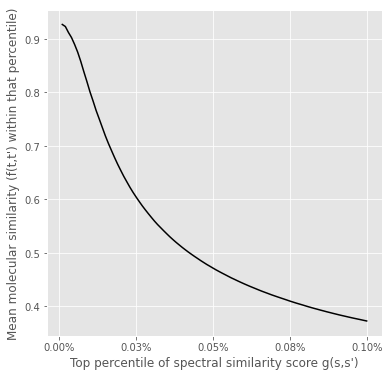

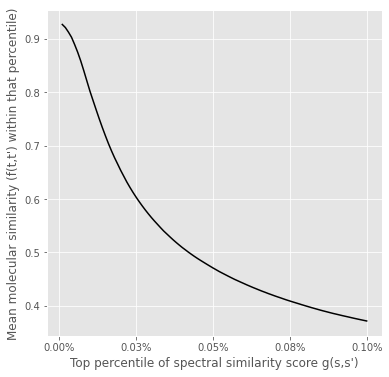

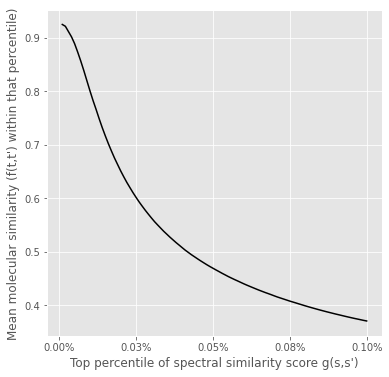

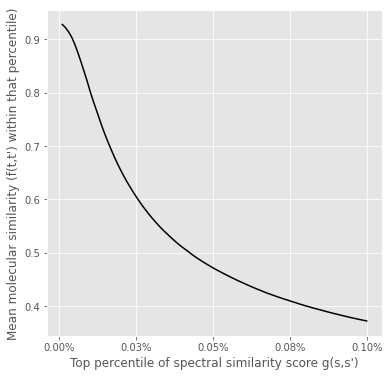

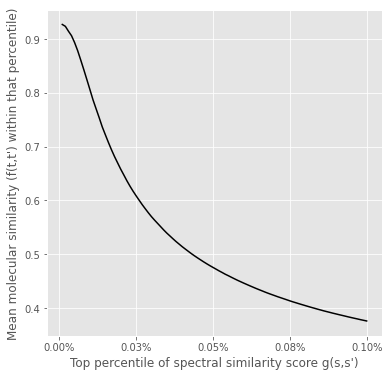

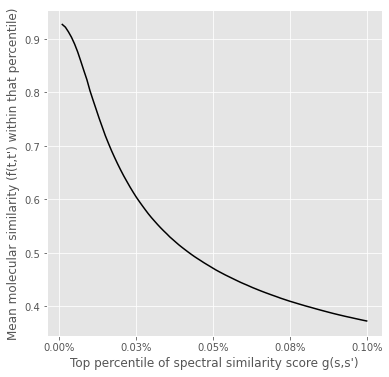

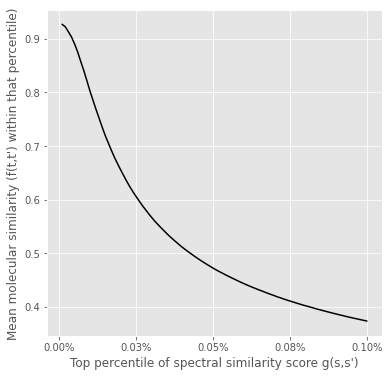

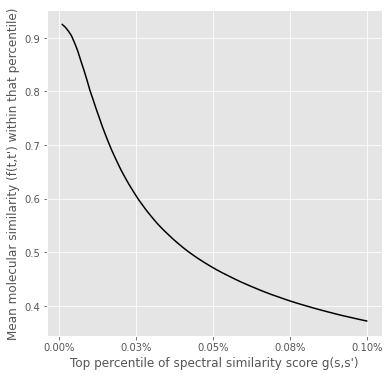

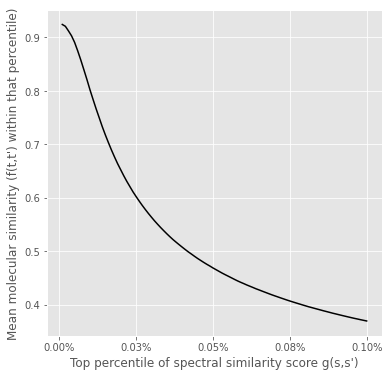

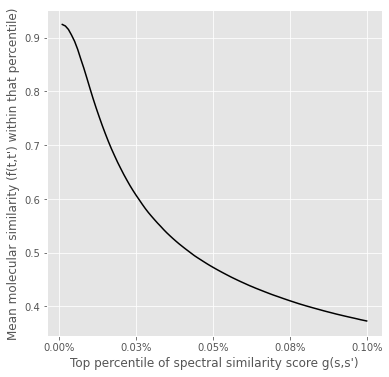

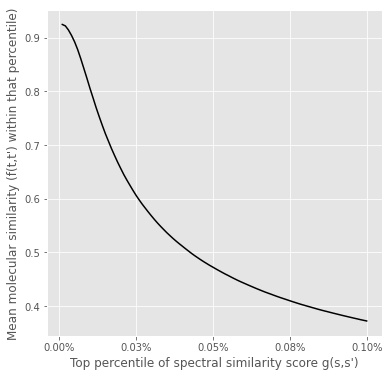

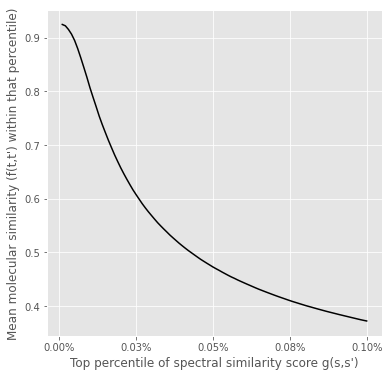

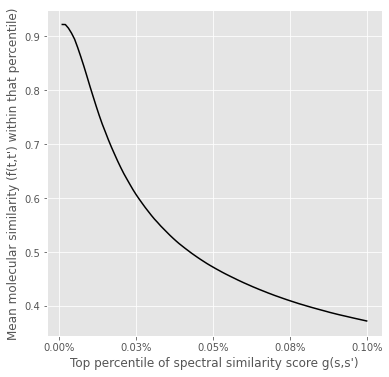

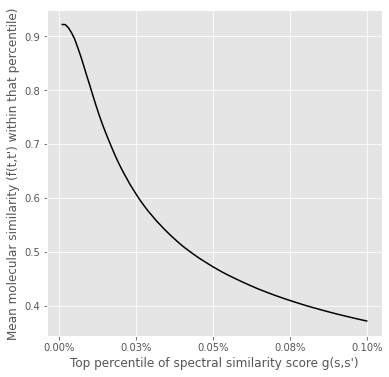

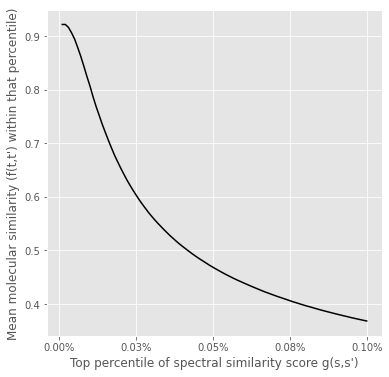

In [64]:
path_models = "gas2vec"

for iteration in [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]:
    filename = f"{model_name}_iter_{iteration}.model"
    model_file = os.path.join(path_models, filename)

    # Load pretrained model
    model = gensim.models.Word2Vec.load(model_file)
    
    # Score calculations
    spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=15)
    similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
    print("u")
    # Compare to reference scores
    percentile_spec2vec = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

    filename = os.path.join("gas2vec/iterations", "percentile_gas2vec_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec)
    
    filename = os.path.join("gas2vec/iterations", "similarities_gas2vec_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec)

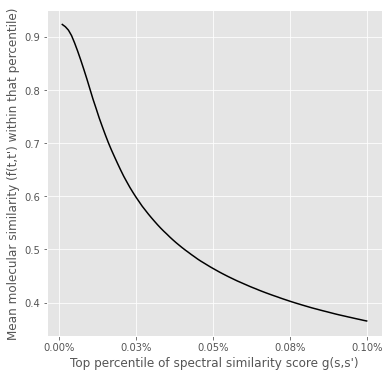

In [68]:
path_models = "gas2vec"

iteration=100

filename = f"{model_name}.model"
model_file = os.path.join(path_models, filename)

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)
    
# Score calculations
spec2vec_similarity = Spec2Vec(model, intensity_weighting_power=0.5, allowed_missing_percentage=15)
similarity_matrix = spec2vec_similarity.matrix(documents, documents, is_symmetric=True)
# Compare to reference scores
percentile_spec2vec = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

filename = os.path.join("gas2vec/iterations", "percentile_gas2vec_iter_{}.npy".format(iteration))
np.save(filename, percentile_spec2vec)
    
filename = os.path.join("gas2vec/iterations", "similarities_gas2vec_iter_{}.npy".format(iteration))
np.save(filename, percentile_spec2vec)

## Compare results

In [5]:
path_data = "gas2vec/iterations"

percentiles = []
for iteration in [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]:
    
    filename = os.path.join(path_data, "percentile_gas2vec_iter_{}.npy".format(iteration))
    percentiles.append(np.load(filename))
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

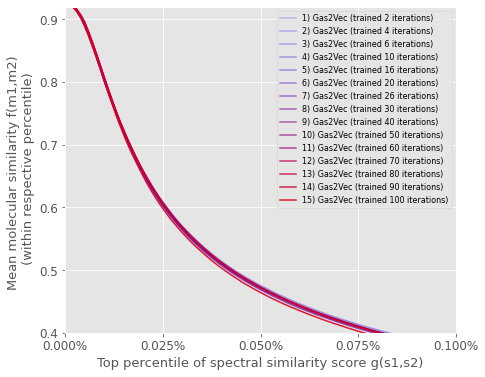

In [6]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]
iterations = [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]
iterations_plot = [2, 4, 6, 10, 16, 20, 26, 30, 40, 50, 60, 70, 80, 90, 100]

color_count = 0
color_max = len(iterations_plot) + 1
for i, percentile in enumerate(percentiles):
    if iterations[i] in iterations_plot:
        plt.plot(x_percentiles, percentiles[i], 
                 color=(color_count/color_max, 0, 1-color_count/color_max, 0.2+0.8*color_count/color_max),
                 label='{}) Gas2Vec (trained {} iterations)'.format((color_count+1), iterations[i]))
        color_count += 1

i = 9    
# plt.plot(x_percentiles, percentiles[i], 
#          "--", color="black",
#          label='selected: Spec2Vec (trained {} iterations on UniqueInchikeys)'.format(iterations[i]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend(fontsize=8)
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
plt.savefig(os.path.join("gas2vec/figures", 'Benchmarking_model_iterations.pdf'))
plt.savefig(os.path.join("gas2vec/figures", 'Benchmarking_model_iterations.eps'))

---